# Forecasting GPU Mining Profitability

In [1]:
import pandas as pd
import numpy as np
import pandas_montecarlo as mc
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

In [360]:
# Get the Data

tickers = ['ETC-USD','ETH-USD']
start = '2019-01-01'
end = '2020-03-01'
data = yf.download(" ".join(tickers), start = start, end = end, interval='1mo').Close
print(data.head())

[*********************100%***********************]  2 of 2 completed
             ETC-USD     ETH-USD
Date                            
2019-01-01  3.953604  107.061012
2019-02-01  4.278264  136.746246
2019-03-01  4.823973  141.514099
2019-04-01  5.899628  162.166031
2019-05-01  8.658670  268.113556


## Graphing the Monthly Closing Prices

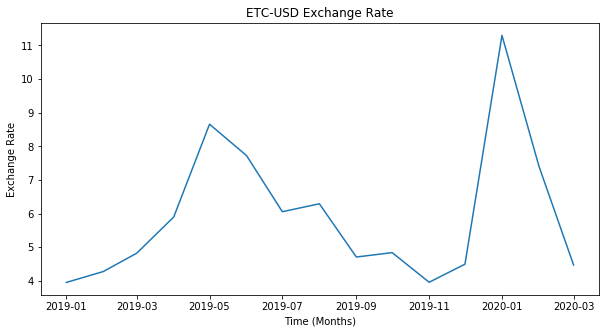

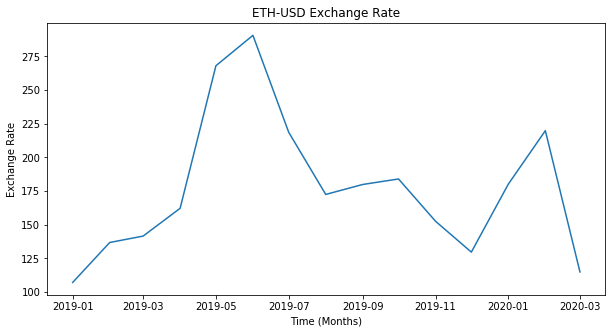

In [361]:
for ticker in tickers:
    plt.rcParams["figure.figsize"]=10,5
    plt.plot(data[ticker])
    plt.xlabel('Time (Months)')
    plt.ylabel('Exchange Rate')
    plt.title(ticker + ' Exchange Rate')
    plt.show()

## Monte-Carlo Variants of the Data

In [362]:
ticker = 'ETH-USD'
returns = data.pct_change().copy()
sims = returns[ticker].copy().dropna().montecarlo(sims=500)

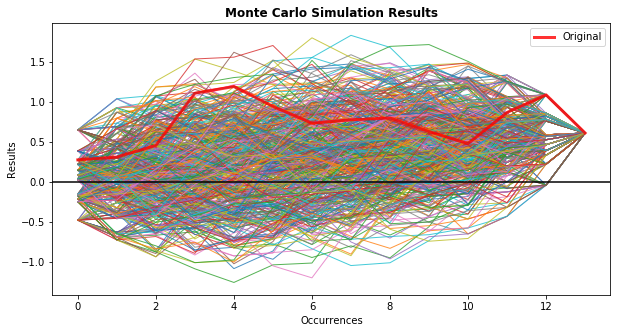

In [363]:
sims.plot()

In [364]:
# Extract Exchange Rate Simulated Values

sims = (sims.data+1.0).cumprod()

In [365]:
sims = sims*data[ticker].iloc[0]

## Simulating the Variation in Network Hashrate

It has been experimentally determined that there is a rough relationship between the explanatory variable - the exchange rate, and the explained variable, the overall network hashrate. Working theory is that the network hashrate is driven by the exchange rate. Where increased prices cause and increase in production across the network. From "Exchange Rate & Hashrate" notebook I've determined that the following is a decent approximation of the network hashrate given the current exchange rate.

\begin{align}
\\Hashrate & = e^a * Lagged ExchangeRate^b * e^{u_t}
\end{align}

With optimal lag period of approximately 3 months, a = 11.001, and b = 0.20301

In [366]:
# Lag the Simulation data
lag_period = 3
lag_sims = sims.shift(lag_period).copy()
lag_sims.dropna(inplace=True)
sims = sims.shift(-lag_period)
sims.dropna(inplace=True)
print(len(lag_sims),len(sims))

11 11


In [367]:
hash_sims = (np.exp(11.01)*lag_sims**0.20301)/1000

## Simulating the Mining Operation

In [404]:
# Card/Rig Specs (very basic)
n_cards = 6
hash_rate = 88.26
power = 219
card_cost = 500
rig_cost = 300

In [405]:
overall_rate = hash_sims
probability = ((n_cards*hash_rate)/overall_rate)*10**-6
block_time = 13.3
blocks_mined = (30*3600*24/block_time)*probability
reward = blocks_mined*2.23601

In [406]:
# Power Useage
monthly = ((n_cards*power+90)*24*30)/1000
rate = 0.07
cost = rate*monthly
print('Monthly Power Cost: $%.2f'%cost)

Monthly Power Cost: $70.76


In [407]:
# Multiply The Simulated Monthly Exchange Rates by the Monthly Reward

In [408]:
dollars = sims*reward - cost if type(reward)==float else sims*reward.values - cost
profit = dollars.sum()
print(stats.mode(profit).mode[0])

202.59942415822604


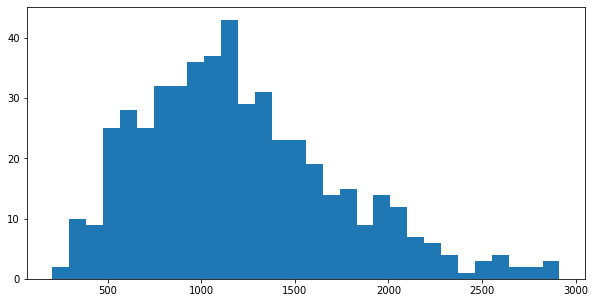

In [409]:
plt.hist(profit, bins=30)
plt.show()

In [410]:
median_profit = profit.median()
monthly = median_profit/len(sims)
print('The most likely profit between %s and %s is $%.2f'%(start,end,median_profit))
print('Monthly income: ${0}'.format(round(monthly,2)))
print('Montly Profit/Cost: {0}'.format(round(monthly/cost,2)))
print('The actual profit was $%.2f'%dollars['original'].sum())

The most likely profit between 2019-01-01 and 2020-03-01 is $1133.84
Monthly income: $103.08
Montly Profit/Cost: 1.46
The actual profit was $2046.09


In [411]:
# Calculating the Cummulative Business Deficit
startup_capital = n_cards*card_cost+rig_cost
deficit = dollars.cumsum()-startup_capital


In [412]:
time = np.arange(0,len(deficit))
X = sm.add_constant(time)
break_even = []
for i in deficit.columns:
    model = sm.OLS(deficit[i],X)
    res = model.fit().params
    break_even.append(-1*res[0]/res[1])

[]

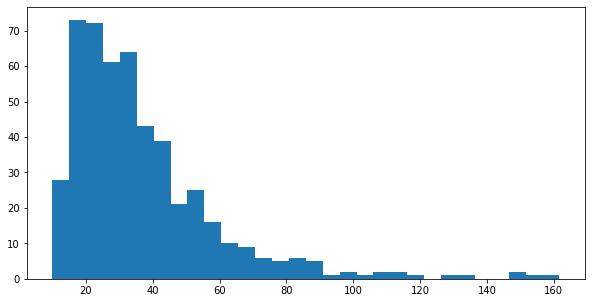

In [413]:
# Plotting the Break Even Histogram
break_even = [i for i in break_even if 0 <i < 175]
plt.hist(break_even, bins=30)
plt.plot()

In [389]:
print('The most probable break even time is %d months'%round(np.median(break_even)))
print('The actual break even time was %d months'%round(break_even[0]))

The most probable break even time is 28 months
The actual break even time was 16 months
